# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

env: CUDA_LAUNCH_BLOCKING=1


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_84448/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_84448/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_84448/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_tes

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-25 21:00:06,775] A new study created in RDB with name: no-name-0e5a9fd4-033d-45ca-a5ce-239eb0a25c72
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:27,  5.16it/s]

current_loss_val:  1.4502943754196167
current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4219261407852173
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.6739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4188977479934692
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:18,  7.71it/s]

current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4180285930633545
current_loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4171319007873535
current_loss: tensor(1.4102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417148470878601
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<02:52, 11.53it/s]

current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417224645614624
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4173319339752197
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4171189069747925
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:53, 11.44it/s]

current_loss_val:  1.4171775579452515
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4171104431152344
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417334794998169
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:33, 12.96it/s]

current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4171905517578125
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417108416557312
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4172863960266113
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:28, 13.31it/s]

current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169851541519165
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169164896011353
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.417033076286316
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:23, 13.83it/s]

current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4168641567230225
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164687395095825
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164843559265137
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:26, 13.45it/s]

current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4164204597473145
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162315130233765
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162065982818604
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:11, 15.05it/s]

current_loss_val:  1.4163049459457397
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162254333496094
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162224531173706
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162272214889526
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:52, 11.43it/s]


current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162417650222778
Early Stop at iteration 28 with minimal loss tensor(1.4162, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:08,  6.48it/s]

current_loss_val:  1.3755308389663696
current_loss: tensor(1.3700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:43,  7.05it/s]

current_loss_val:  1.3011841773986816
current_loss: tensor(1.3217, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2878999710083008
current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:22,  7.62it/s]

current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2844321727752686


  0%|          | 5/2000 [00:00<04:17,  7.75it/s]

current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27927565574646
current_loss: tensor(1.2931, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:41,  7.09it/s]

current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27764093875885
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:30,  7.38it/s]

current_loss_val:  1.2768325805664062


  0%|          | 8/2000 [00:01<04:51,  6.82it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756260633468628
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:42,  7.05it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274154543876648
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:31,  7.32it/s]

current_loss_val:  1.27300226688385


  1%|          | 11/2000 [00:01<04:25,  7.50it/s]

current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698051929473877
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2851, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:47,  6.91it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665256261825562
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:35,  7.20it/s]

current_loss_val:  1.262817144393921


  1%|          | 14/2000 [00:01<04:29,  7.37it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591140270233154
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:23,  7.52it/s]

current_loss_val:  1.257243275642395
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:45,  6.95it/s]

current_loss_val:  1.2554353475570679


  1%|          | 17/2000 [00:02<04:34,  7.22it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539254426956177
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:26,  7.43it/s]

current_loss_val:  1.2533856630325317
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:47,  6.90it/s]

current_loss_val:  1.2530666589736938


  1%|          | 20/2000 [00:02<04:36,  7.17it/s]

current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528278827667236
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:21,  7.57it/s]

current_loss_val:  1.2526048421859741
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2511543035507202
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:34,  7.20it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2497342824935913
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:23,  7.51it/s]

current_loss_val:  1.2495672702789307
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490675449371338
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<04:19,  7.62it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2483105659484863
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<04:31,  7.25it/s]

current_loss_val:  1.248453140258789
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485127449035645
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:24,  7.45it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485849857330322
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<04:20,  7.56it/s]

current_loss_val:  1.2482261657714844
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<05:04,  6.46it/s]

current_loss_val:  1.247605562210083


  2%|▏         | 32/2000 [00:04<04:53,  6.71it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471331357955933
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<04:28,  7.31it/s]

current_loss_val:  1.2467893362045288
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467960119247437
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:04<04:48,  6.81it/s]

current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467052936553955
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<05:02,  6.49it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460718154907227
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<04:45,  6.88it/s]

current_loss_val:  1.2458579540252686


  2%|▏         | 38/2000 [00:05<05:00,  6.54it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245741844177246
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<06:24,  5.10it/s]

current_loss_val:  1.2452744245529175
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451250553131104


  2%|▏         | 40/2000 [00:05<07:09,  4.56it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:06<07:41,  4.24it/s]

current_loss_val:  1.2448588609695435
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:06<08:37,  3.78it/s]

current_loss_val:  1.2446136474609375
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<10:31,  3.10it/s]

current_loss_val:  1.2435857057571411
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:07<09:42,  3.36it/s]

current_loss_val:  1.2419532537460327
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:07<08:57,  3.64it/s]

current_loss_val:  1.2414029836654663
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:07<09:34,  3.40it/s]

current_loss_val:  1.241269826889038
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:08<11:34,  2.81it/s]

current_loss_val:  1.2411283254623413
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:08<11:15,  2.89it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410523891448975
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:09<12:59,  2.50it/s]

current_loss_val:  1.2404290437698364
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:10<18:17,  1.78it/s]

current_loss_val:  1.2402303218841553
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:10<21:47,  1.49it/s]

current_loss_val:  1.2402093410491943
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:11<22:06,  1.47it/s]

current_loss_val:  1.2398566007614136
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:12<19:36,  1.65it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395843267440796
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:12<17:14,  1.88it/s]

current_loss_val:  1.2396180629730225
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:12<15:30,  2.09it/s]

current_loss_val:  1.2396963834762573
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:13<14:59,  2.16it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397844791412354
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:13<14:59,  2.16it/s]

current_loss_val:  1.2397658824920654
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:14<07:57,  4.07it/s]

current_loss_val:  1.2397650480270386
Early Stop at iteration 57 with minimal loss tensor(1.2396, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:29,405] Trial 0 finished with value: -2.47916841506958 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.250690114456665, 'penalty_decorrelation_ridge_second_difference': 1.2152276890981812}. Best is trial 0 with value: -2.47916841506958.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:05,  3.00it/s]

current_loss_val:  1.2395247220993042
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:06,  3.29it/s]

current_loss_val:  1.2394373416900635
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:17,  3.58it/s]

current_loss_val:  1.2384756803512573
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:30,  3.91it/s]

current_loss_val:  1.2377216815948486
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:59,  3.70it/s]

current_loss_val:  1.2370771169662476
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:59,  4.15it/s]

current_loss_val:  1.2371686697006226
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372658252716064
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:30,  3.90it/s]

current_loss_val:  1.2375574111938477
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:13,  4.04it/s]

current_loss_val:  1.2375801801681519
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:39,  3.44it/s]

current_loss_val:  1.2375413179397583
Early Stop at iteration 9 with minimal loss tensor(1.2371, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:33,489] Trial 1 finished with value: -2.474153995513916 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.6835850735706517, 'penalty_decorrelation_ridge_second_difference': 6.859738128139319}. Best is trial 1 with value: -2.474153995513916.
  0%|          | 1/2000 [00:00<05:40,  5.88it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395830154418945
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394914627075195
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393920421600342


  0%|          | 4/2000 [00:00<04:24,  7.54it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389384508132935
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:16,  7.79it/s]

current_loss_val:  1.2383010387420654
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376389503479004
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:13,  7.85it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236936092376709
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:31,  7.34it/s]

current_loss_val:  1.2368693351745605
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236865758895874
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 11/2000 [00:01<04:18,  7.70it/s]

tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368706464767456
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368274927139282


  1%|          | 12/2000 [00:01<04:16,  7.76it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368061542510986
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:38,  7.12it/s]

current_loss_val:  1.2368214130401611
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368555068969727


  1%|          | 15/2000 [00:02<04:52,  6.79it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368559837341309
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:47,  6.89it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368773221969604
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368203401565552
Early Stop at iteration 16 with minimal loss tensor(1.2368, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:37,467] Trial 2 finished with value: -2.4736123085021973 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8057595912529463, 'penalty_decorrelation_ridge_second_difference': 20.154098669863295}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:46,  5.76it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397570610046387
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.35it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398884296417236
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240037441253662


  0%|          | 4/2000 [00:00<04:22,  7.59it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405023574829102
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:19,  6.24it/s]

current_loss_val:  1.2411562204360962
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241690754890442
Early Stop at iteration 5 with minimal loss tensor(1.2398, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:40,366] Trial 3 finished with value: -2.4795138835906982 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.367226933198467, 'penalty_decorrelation_ridge_second_difference': 27.120340184485226}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<06:46,  4.91it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396985292434692
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:16,  6.30it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239738941192627
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:49,  6.89it/s]

current_loss_val:  1.239782452583313
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399629354476929
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:42,  7.07it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401376962661743
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:59,  5.54it/s]


current_loss_val:  1.2403591871261597
Early Stop at iteration 5 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:00:42,721] Trial 4 finished with value: -2.4793970584869385 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.421326248011287, 'penalty_decorrelation_ridge_second_difference': 15.368082266504556}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239572525024414
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395470142364502
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394074201583862


  0%|          | 4/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392303943634033
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.2386326789855957
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383943796157837
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:13,  7.85it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238289713859558
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377588748931885


  0%|          | 9/2000 [00:01<04:11,  7.92it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377456426620483
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:08,  7.99it/s]

current_loss_val:  1.2376430034637451
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376545667648315
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:12,  7.88it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376863956451416
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378535270690918


  1%|          | 14/2000 [00:01<04:10,  7.92it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380409240722656
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:33,  7.26it/s]


current_loss_val:  1.2382677793502808
Early Stop at iteration 14 with minimal loss tensor(1.2376, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:00:46,455] Trial 5 finished with value: -2.475285530090332 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.442672245799002, 'penalty_decorrelation_ridge_second_difference': 6.804588438820341}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:51,  5.69it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398812770843506
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401237487792969
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405849695205688


  0%|          | 4/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419930696487427
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:22,  6.18it/s]

current_loss_val:  1.2429234981536865
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430710792541504
Early Stop at iteration 5 with minimal loss tensor(1.2399, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:48,604] Trial 6 finished with value: -2.479762554168701 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.84730767158508, 'penalty_decorrelation_ridge_second_difference': 23.607099354967186}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:46,  5.76it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395883798599243
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395102977752686
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394126653671265


  0%|          | 4/2000 [00:00<04:25,  7.53it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391283512115479
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:18,  7.71it/s]

current_loss_val:  1.2385029792785645
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2379096746444702
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:16,  7.77it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375520467758179
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:33,  7.29it/s]

current_loss_val:  1.2373640537261963
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237220048904419
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:21,  7.61it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371737957000732
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370593547821045


  1%|          | 12/2000 [00:01<04:16,  7.75it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369163036346436
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:12,  7.86it/s]

current_loss_val:  1.2368406057357788
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368175983428955
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:12,  7.87it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236836314201355
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236865758895874


  1%|          | 17/2000 [00:02<04:11,  7.89it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368693351745605
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:37,  7.14it/s]

current_loss_val:  1.236842155456543
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368230819702148
Early Stop at iteration 18 with minimal loss tensor(1.2368, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:52,537] Trial 7 finished with value: -2.473634958267212 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8949157791755398, 'penalty_decorrelation_ridge_second_difference': 14.534679748414867}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:57,  5.59it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399290800094604
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:36,  7.24it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401758432388306
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406587600708008


  0%|          | 4/2000 [00:00<04:26,  7.48it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426414489746094
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:41,  4.97it/s]

current_loss_val:  1.2428216934204102
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428491115570068
Early Stop at iteration 5 with minimal loss tensor(1.2399, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:54,905] Trial 8 finished with value: -2.479857921600342 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.482044595999756, 'penalty_decorrelation_ridge_second_difference': 15.47728123350426}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396891117095947
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.42it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239719271659851
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239756464958191


  0%|          | 4/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239898443222046
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:19,  6.24it/s]

current_loss_val:  1.2400239706039429
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401763200759888
Early Stop at iteration 5 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:00:56,481] Trial 9 finished with value: -2.4793782234191895 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.883541722408781, 'penalty_decorrelation_ridge_second_difference': 14.586019568741067}. Best is trial 2 with value: -2.4736123085021973.
  0%|          | 1/2000 [00:00<05:45,  5.78it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395561933517456
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394311428070068
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391339540481567
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<09:41,  3.43it/s]

current_loss_val:  1.2385845184326172
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:28,  3.17it/s]

current_loss_val:  1.2376927137374878
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372604608535767
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:04,  4.69it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372242212295532
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23703134059906


  0%|          | 9/2000 [00:02<06:13,  5.33it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370632886886597
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<05:10,  6.41it/s]

current_loss_val:  1.2370766401290894
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237115740776062
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<04:52,  6.80it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370418310165405
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:44,  6.99it/s]

current_loss_val:  1.2370206117630005
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369221448898315
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<04:29,  7.37it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369205951690674
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369089126586914


  1%|          | 17/2000 [00:03<04:25,  7.48it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368426322937012
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<04:18,  7.68it/s]

current_loss_val:  1.236810564994812
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236809253692627
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<04:13,  7.81it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367942333221436
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367665767669678


  1%|          | 22/2000 [00:03<04:12,  7.83it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367078065872192
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:04<04:30,  7.31it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366652488708496
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366410493850708


  1%|▏         | 25/2000 [00:04<04:24,  7.47it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365267276763916
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<04:17,  7.66it/s]

current_loss_val:  1.2365862131118774
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365518808364868
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<04:12,  7.81it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365537881851196
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366909980773926


  1%|▏         | 29/2000 [00:04<05:28,  6.01it/s]


current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365849018096924
Early Stop at iteration 29 with minimal loss tensor(1.2365, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:02,540] Trial 10 finished with value: -2.473053216934204 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7390858239566119, 'penalty_decorrelation_ridge_second_difference': 13.483666493564655}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<07:35,  4.39it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395492792129517


  0%|          | 2/2000 [00:00<05:58,  5.57it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394784688949585
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391010522842407


  0%|          | 3/2000 [00:00<08:22,  3.97it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<13:00,  2.56it/s]

current_loss_val:  1.2386236190795898
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<15:58,  2.08it/s]

current_loss_val:  1.2377678155899048
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<17:36,  1.89it/s]

current_loss_val:  1.2376477718353271
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:03<18:30,  1.79it/s]

current_loss_val:  1.2376770973205566
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<19:38,  1.69it/s]

current_loss_val:  1.2377703189849854
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:04<20:55,  1.59it/s]

current_loss_val:  1.2377756834030151
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:04<18:43,  1.77it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378073930740356
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:05<18:27,  1.80it/s]

current_loss_val:  1.237817406654358
Early Stop at iteration 10 with minimal loss tensor(1.2376, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:09,996] Trial 11 finished with value: -2.475295305252075 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.102813280248382, 'penalty_decorrelation_ridge_second_difference': 8.75861387679953}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:03,  3.01it/s]

current_loss_val:  1.2396377325057983
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:05,  3.30it/s]

current_loss_val:  1.2396316528320312
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:30,  3.50it/s]

current_loss_val:  1.2396289110183716
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:06,  3.29it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239585041999817


  0%|          | 5/2000 [00:01<09:49,  3.38it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394732236862183


  0%|          | 6/2000 [00:01<09:44,  3.41it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392054796218872
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:31,  3.49it/s]

current_loss_val:  1.2384817600250244
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:55,  3.72it/s]

current_loss_val:  1.2382094860076904
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:01,  3.67it/s]

current_loss_val:  1.2382014989852905
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:30,  3.90it/s]

current_loss_val:  1.2381882667541504
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<08:48,  3.76it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381634712219238
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:50,  3.74it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381017208099365
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:52,  3.73it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238053560256958
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:46,  3.77it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238031029701233
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<07:08,  4.63it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2379424571990967
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2379623651504517


  1%|          | 17/2000 [00:04<06:16,  5.27it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380136251449585
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<05:14,  6.29it/s]

current_loss_val:  1.2380971908569336
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238264799118042
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<08:14,  4.01it/s]


current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383666038513184
Early Stop at iteration 19 with minimal loss tensor(1.2379, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:16,159] Trial 12 finished with value: -2.4758846759796143 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.761938380149384, 'penalty_decorrelation_ridge_second_difference': 21.561089289706768}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396160364151
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:36,  7.21it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396433353424072
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23976469039917


  0%|          | 4/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398375272750854
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:25,  6.13it/s]

current_loss_val:  1.2401721477508545
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402423620224
Early Stop at iteration 5 with minimal loss tensor(1.2396, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:18,675] Trial 13 finished with value: -2.479231834411621 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.200978919328872, 'penalty_decorrelation_ridge_second_difference': 3.0223715080024296}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<04:11,  7.96it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240573763847351
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:14,  7.86it/s]

current_loss_val:  1.2403247356414795
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404427528381348
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:12,  7.90it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241024136543274
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241844654083252


  0%|          | 6/2000 [00:00<04:12,  7.88it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436599731445312
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:09,  6.44it/s]


current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437987327575684
Early Stop at iteration 6 with minimal loss tensor(1.2403, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:21,583] Trial 14 finished with value: -2.480649471282959 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.980843632688075, 'penalty_decorrelation_ridge_second_difference': 9.129258861747028}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:45,  5.79it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395964860916138
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:37,  7.21it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395554780960083
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395135164260864


  0%|          | 4/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393306493759155
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:23,  7.58it/s]

current_loss_val:  1.238914132118225
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377268075942993
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:16,  7.76it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237139344215393
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372186183929443


  0%|          | 9/2000 [00:01<04:15,  7.78it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372817993164062
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:16,  7.76it/s]

current_loss_val:  1.237393856048584
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374593019485474
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:45,  6.96it/s]


current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374825477600098
Early Stop at iteration 11 with minimal loss tensor(1.2371, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:24,987] Trial 15 finished with value: -2.4742789268493652 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6358434991484386, 'penalty_decorrelation_ridge_second_difference': 27.3932220937214}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396628856658936
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:37,  7.20it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397053241729736
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397336959838867


  0%|          | 4/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397866249084473
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:39,  5.88it/s]

current_loss_val:  1.23985755443573
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399632930755615
Early Stop at iteration 5 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:27,150] Trial 16 finished with value: -2.479325771331787 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.684574179644262, 'penalty_decorrelation_ridge_second_difference': 29.38925183656211}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395682334899902
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394466400146484
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392593622207642


  0%|          | 4/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238763451576233
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:23,  7.56it/s]

current_loss_val:  1.2378745079040527
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372976541519165
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:17,  7.73it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371628284454346
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369892597198486


  0%|          | 9/2000 [00:01<04:16,  7.76it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368589639663696
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:16,  7.74it/s]

current_loss_val:  1.2368748188018799
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369556427001953
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:11,  7.90it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371330261230469
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372580766677856


  1%|          | 13/2000 [00:01<04:41,  7.06it/s]


current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374382019042969
Early Stop at iteration 13 with minimal loss tensor(1.2369, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:31,041] Trial 17 finished with value: -2.473717451095581 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7147953751713932, 'penalty_decorrelation_ridge_second_difference': 15.832934959737239}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395797967910767
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:36,  7.23it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394800186157227
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239367961883545


  0%|          | 4/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238887071609497
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:21,  7.62it/s]

current_loss_val:  1.2381994724273682
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237529993057251
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:20,  7.64it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369279861450195
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:37,  7.16it/s]

current_loss_val:  1.2368850708007812
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368651628494263
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:26,  7.48it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368075847625732
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367571592330933


  1%|          | 12/2000 [00:01<04:25,  7.48it/s]

current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367180585861206
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:21,  7.58it/s]

current_loss_val:  1.236724615097046
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236742377281189
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:17,  7.70it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367225885391235
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367022037506104


  1%|          | 17/2000 [00:02<04:36,  7.18it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366703748703003
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:58,  6.64it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366516590118408
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<04:39,  7.08it/s]

current_loss_val:  1.2366164922714233
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236572027206421
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:27,  7.41it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365962266921997
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365885972976685


  1%|          | 23/2000 [00:03<04:22,  7.53it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365931272506714
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:39,  7.06it/s]

current_loss_val:  1.2366182804107666
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366310358047485
Early Stop at iteration 24 with minimal loss tensor(1.2366, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:36,319] Trial 18 finished with value: -2.473144054412842 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5012782434956102, 'penalty_decorrelation_ridge_second_difference': 19.764473530511086}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239676594734192
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:36,  7.23it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397119998931885
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397452592849731


  0%|          | 4/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239837646484375
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:25,  6.12it/s]

current_loss_val:  1.239915132522583
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240039348602295
Early Stop at iteration 5 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:38,536] Trial 19 finished with value: -2.4793527126312256 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.843345037775178, 'penalty_decorrelation_ridge_second_difference': 21.09015690340854}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<06:52,  4.85it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239505410194397


  0%|          | 2/2000 [00:00<06:14,  5.33it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389423847198486
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:02,  6.59it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237366795539856
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374019622802734


  0%|          | 5/2000 [00:00<04:42,  7.07it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237021565437317
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:25,  7.52it/s]

current_loss_val:  1.236754059791565
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368083000183105
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:21,  7.62it/s]

current_loss_val:  1.2368990182876587
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371026277542114
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:07,  6.47it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371108531951904
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370984554290771
Early Stop at iteration 10 with minimal loss tensor(1.2368, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:01:41,950] Trial 20 finished with value: -2.47350811958313 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.1710352197595024, 'penalty_decorrelation_ridge_second_difference': 2.5772716147869073}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<06:43,  4.95it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395151853561401
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:48,  6.91it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393884658813477
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381350994110107


  0%|          | 4/2000 [00:00<04:35,  7.23it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373018264770508
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:26,  7.49it/s]

current_loss_val:  1.2368519306182861
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368780374526978
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:20,  7.64it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236939787864685
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372254133224487


  0%|          | 9/2000 [00:01<04:46,  6.95it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372161149978638
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:11,  6.39it/s]


current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371917963027954
Early Stop at iteration 9 with minimal loss tensor(1.2369, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:45,464] Trial 21 finished with value: -2.4737040996551514 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1474111662858827, 'penalty_decorrelation_ridge_second_difference': 8.04300030333285}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<07:01,  4.74it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395107746124268
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<06:38,  5.01it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389394044876099
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:18,  6.26it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374906539916992
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375872135162354


  0%|          | 5/2000 [00:00<04:59,  6.65it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378003597259521
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:38,  7.15it/s]

current_loss_val:  1.2375974655151367
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373372316360474
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:26,  7.47it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370271682739258
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237056016921997


  0%|          | 10/2000 [00:01<04:24,  7.53it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237205147743225
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:21,  7.61it/s]

current_loss_val:  1.2374837398529053
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375022172927856
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<05:06,  6.48it/s]


current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375153303146362
Early Stop at iteration 12 with minimal loss tensor(1.2370, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:49,354] Trial 22 finished with value: -2.4740540981292725 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.888623891704326, 'penalty_decorrelation_ridge_second_difference': 0.8524703311861506}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396090030670166
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:37,  7.19it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395718097686768
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239532470703125


  0%|          | 4/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239425539970398
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:26,  7.47it/s]

current_loss_val:  1.2391058206558228
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238684058189392
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:23,  7.56it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238211750984192
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:44,  6.99it/s]

current_loss_val:  1.2378095388412476
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376207113265991
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:29,  7.39it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23762047290802
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376573085784912


  1%|          | 12/2000 [00:01<04:24,  7.51it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377240657806396
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:21,  7.61it/s]

current_loss_val:  1.2378158569335938
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23799729347229
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:48,  6.89it/s]


current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238358974456787
Early Stop at iteration 14 with minimal loss tensor(1.2376, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:52,543] Trial 23 finished with value: -2.475240707397461 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.675370188538434, 'penalty_decorrelation_ridge_second_difference': 11.876988657770378}. Best is trial 10 with value: -2.473053216934204.
  0%|          | 1/2000 [00:00<05:50,  5.70it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394953966140747
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:48,  5.73it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387511730194092
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:49,  6.89it/s]

current_loss_val:  1.2370238304138184
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237210988998413
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373342514038086
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:49,  6.88it/s]

current_loss_val:  1.2372268438339233
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370989322662354
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:29,  7.40it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368011474609375
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367525100708008


  0%|          | 10/2000 [00:01<04:48,  6.89it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367522716522217
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:44,  7.00it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367292642593384
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:13,  6.34it/s]

current_loss_val:  1.236575961112976
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365843057632446


  1%|          | 14/2000 [00:02<05:24,  6.13it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236569881439209
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:50,  6.82it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364636659622192
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237004041671753


  1%|          | 17/2000 [00:02<04:37,  7.16it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236831545829773
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:30,  7.33it/s]

current_loss_val:  1.2367359399795532
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236556887626648
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<05:01,  6.56it/s]


current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364989519119263
Early Stop at iteration 19 with minimal loss tensor(1.2365, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:01:57,206] Trial 24 finished with value: -2.4729273319244385 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.524712291407699, 'penalty_decorrelation_ridge_second_difference': 1.2076590764202098}. Best is trial 24 with value: -2.4729273319244385.
  0%|          | 1/2000 [00:00<05:45,  5.78it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395845651626587
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:34,  7.29it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394917011260986
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393919229507446


  0%|          | 4/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389644384384155
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:28,  7.43it/s]

current_loss_val:  1.2383217811584473
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376699447631836
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:21,  7.63it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370295524597168
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:42,  7.05it/s]

current_loss_val:  1.2369810342788696
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369544506072998
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:31,  7.34it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368831634521484
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:42,  7.03it/s]

current_loss_val:  1.2368284463882446
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367660999298096
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:32,  7.30it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236742615699768
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367527484893799


  1%|          | 15/2000 [00:02<04:27,  7.41it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367514371871948
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:24,  7.51it/s]

current_loss_val:  1.2367421388626099
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367182970046997
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:19,  7.63it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367024421691895
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366877794265747


  1%|          | 20/2000 [00:02<04:18,  7.67it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367346286773682
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<04:19,  7.63it/s]

current_loss_val:  1.236720085144043
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367149591445923
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<04:38,  7.09it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236700177192688
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366985082626343
Early Stop at iteration 23 with minimal loss tensor(1.2367, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:02:02,720] Trial 25 finished with value: -2.4733755588531494 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3915055833283139, 'penalty_decorrelation_ridge_second_difference': 18.86307092935232}. Best is trial 24 with value: -2.4729273319244385.
  0%|          | 1/2000 [00:00<05:51,  5.69it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395566701889038
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:41,  7.09it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394325733184814
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391401529312134


  0%|          | 4/2000 [00:00<04:33,  7.31it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23859703540802
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:28,  7.43it/s]

current_loss_val:  1.2377021312713623
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237268328666687
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:15,  7.80it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372297048568726
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370227575302124
current_loss: 

  0%|          | 9/2000 [00:01<04:22,  7.59it/s]

tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237057089805603
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:23,  7.55it/s]

current_loss_val:  1.2370637655258179
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371177673339844
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:19,  7.65it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371079921722412
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370085716247559


  1%|          | 14/2000 [00:01<04:19,  7.64it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369576692581177
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:20,  7.61it/s]

current_loss_val:  1.236902117729187
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367984056472778
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:38,  7.11it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367827892303467
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:30,  7.34it/s]

current_loss_val:  1.2367539405822754
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366931438446045
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<04:25,  7.46it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366242408752441
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236557960510254


  1%|          | 22/2000 [00:02<04:22,  7.54it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365460395812988
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<04:48,  6.86it/s]

current_loss_val:  1.2365093231201172
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364944219589233


  1%|▏         | 25/2000 [00:03<04:38,  7.09it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236488699913025
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:28,  7.35it/s]

current_loss_val:  1.2365167140960693
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365223169326782
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:21,  7.55it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366880178451538
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366071939468384


  1%|▏         | 29/2000 [00:04<04:34,  7.18it/s]


current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365996837615967
Early Stop at iteration 29 with minimal loss tensor(1.2365, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:02:08,394] Trial 26 finished with value: -2.472977638244629 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.801031465393456, 'penalty_decorrelation_ridge_second_difference': 13.484894246521389}. Best is trial 24 with value: -2.4729273319244385.
  0%|          | 1/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395412921905518
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:39,  7.15it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394262552261353
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238925576210022


  0%|          | 4/2000 [00:00<04:27,  7.46it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2382605075836182
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:47,  6.94it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376586198806763
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372527122497559


  0%|          | 7/2000 [00:01<04:42,  7.05it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369331121444702
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:31,  7.34it/s]

current_loss_val:  1.2369143962860107
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368797063827515
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:24,  7.53it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367831468582153
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236755132675171


  1%|          | 12/2000 [00:01<04:42,  7.04it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367547750473022
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:31,  7.31it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368687391281128
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368197441101074


  1%|          | 15/2000 [00:02<04:30,  7.35it/s]

current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236846685409546
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:51,  6.80it/s]

current_loss_val:  1.2369422912597656
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368910312652588
Early Stop at iteration 16 with minimal loss tensor(1.2368, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:02:12,630] Trial 27 finished with value: -2.4735093116760254 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0957970885190558, 'penalty_decorrelation_ridge_second_difference': 10.852492769553498}. Best is trial 24 with value: -2.4729273319244385.
  0%|          | 1/2000 [00:00<05:52,  5.67it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396068572998047
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:42,  7.08it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396000623703003
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395873069763184


  0%|          | 4/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239546298980713
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.45it/s]

current_loss_val:  1.2393509149551392


  0%|          | 6/2000 [00:01<06:45,  4.91it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239119291305542
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:28,  6.07it/s]

current_loss_val:  1.2388789653778076
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378897666931152
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:51,  6.84it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376338243484497
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376439571380615


  1%|          | 11/2000 [00:01<04:40,  7.09it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378289699554443
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:49,  6.87it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237841010093689
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378448247909546


  1%|          | 13/2000 [00:02<05:24,  6.12it/s]


current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237998127937317
Early Stop at iteration 13 with minimal loss tensor(1.2376, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-25 21:02:16,335] Trial 28 finished with value: -2.4752676486968994 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.710115896460207, 'penalty_decorrelation_ridge_second_difference': 7.717138192784916}. Best is trial 24 with value: -2.4729273319244385.
  0%|          | 1/2000 [00:00<05:39,  5.88it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394860982894897
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388381958007812
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:53,  6.80it/s]

current_loss_val:  1.2368003129959106
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237488865852356
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372853755950928
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367429733276367


  0%|          | 7/2000 [00:01<04:57,  6.69it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367606163024902
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:37,  5.90it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236911654472351
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 10/2000 [00:01<05:02,  6.57it/s]

tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368067502975464
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366214990615845


  1%|          | 11/2000 [00:01<04:50,  6.84it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364170551300049
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:36,  7.20it/s]

current_loss_val:  1.2364728450775146
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366664409637451
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:56,  6.69it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367572784423828
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<05:16,  6.27it/s]

current_loss_val:  1.236814260482788
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370872497558594
Early Stop at iteration 15 with minimal loss tensor(1.2364, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-25 21:02:20,266] Trial 29 finished with value: -2.4728338718414307 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7260093235432314, 'penalty_decorrelation_ridge_second_difference': 1.395840318275022}. Best is trial 29 with value: -2.4728338718414307.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:03, 15.76it/s]

current_loss: tensor(1.4441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.6739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:03, 15.65it/s]

current_loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:58, 16.86it/s]

current_loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:57, 17.05it/s]

current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:56, 17.34it/s]

current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:51, 19.13it/s]

current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:51, 18.91it/s]

current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<00:53, 18.21it/s]

current_loss: tensor(1.4096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:01<00:49, 19.55it/s]

current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:01<00:47, 20.33it/s]

current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:01<00:47, 20.12it/s]

current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:02<00:50, 18.93it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:02<00:48, 19.90it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:02<00:46, 20.33it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:02<00:47, 20.12it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:02<00:46, 20.36it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:03<00:48, 19.41it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:03<00:45, 20.65it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:03<00:51, 18.02it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:03<00:48, 18.97it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 77/1000 [00:04<00:53, 17.34it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:04<00:52, 17.61it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:04<00:57, 15.87it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:04<00:51, 17.63it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:04<00:48, 18.54it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:05<00:46, 19.62it/s]

current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:05<00:44, 20.27it/s]

current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:05<00:47, 18.68it/s]

current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:05<00:45, 19.72it/s]

current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:05<00:43, 20.57it/s]

current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:06<00:41, 21.16it/s]

current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 122/1000 [00:06<00:47, 18.35it/s]

current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:06<00:44, 19.68it/s]

current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 130/1000 [00:06<00:42, 20.58it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:06<00:42, 20.27it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 138/1000 [00:07<00:46, 18.62it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 140/1000 [00:07<00:46, 18.62it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 144/1000 [00:07<00:53, 15.88it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:07<00:52, 16.12it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 152/1000 [00:08<00:47, 18.01it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 157/1000 [00:08<00:44, 19.15it/s]

current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 159/1000 [00:08<00:49, 17.14it/s]

current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▋        | 165/1000 [00:08<00:41, 19.97it/s]

current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 168/1000 [00:08<00:43, 19.12it/s]

current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 173/1000 [00:09<00:42, 19.51it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 179/1000 [00:09<00:38, 21.17it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 182/1000 [00:09<00:39, 20.70it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 188/1000 [00:09<00:37, 21.71it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 191/1000 [00:10<00:38, 21.08it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 194/1000 [00:10<00:42, 18.79it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|█▉        | 198/1000 [00:10<00:56, 14.27it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 200/1000 [00:10<01:04, 12.32it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 202/1000 [00:11<01:16, 10.48it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 204/1000 [00:11<01:22,  9.66it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 208/1000 [00:11<01:36,  8.19it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 210/1000 [00:12<01:25,  9.24it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 212/1000 [00:12<01:27,  9.06it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██▏       | 214/1000 [00:13<02:42,  4.83it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 215/1000 [00:14<04:29,  2.91it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 216/1000 [00:15<06:53,  1.90it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 217/1000 [00:16<09:04,  1.44it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 218/1000 [00:18<10:54,  1.19it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 218/1000 [00:18<01:07, 11.50it/s]

current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 218 with minimal loss tensor(1.4080, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<04:01,  4.14it/s]

current_loss: tensor(1.4070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3760569095611572
current_loss: tensor(1.3683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:01<09:27,  1.76it/s]

current_loss_val:  1.3488956689834595
current_loss: tensor(1.3629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:01<10:45,  1.55it/s]

current_loss_val:  1.346524715423584
current_loss: tensor(1.3533, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:02<09:03,  1.83it/s]

current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286719560623169
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:02<07:15,  2.28it/s]

current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2804388999938965
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:02<06:16,  2.64it/s]

current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2771438360214233


  1%|          | 7/1000 [00:02<05:39,  2.93it/s]

current_loss: tensor(1.2800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.277173399925232


  1%|          | 8/1000 [00:03<05:12,  3.18it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741882801055908


  1%|          | 9/1000 [00:03<04:49,  3.42it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270676851272583


  1%|          | 10/1000 [00:03<04:34,  3.61it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684016227722168


  1%|          | 11/1000 [00:03<04:21,  3.78it/s]

current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659822702407837


  1%|          | 12/1000 [00:04<04:10,  3.95it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656240463256836


  1%|▏         | 13/1000 [00:04<04:04,  4.04it/s]

current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657722234725952


  1%|▏         | 14/1000 [00:04<04:11,  3.92it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649807929992676


  2%|▏         | 15/1000 [00:04<04:04,  4.02it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621347904205322


  2%|▏         | 16/1000 [00:05<03:53,  4.21it/s]

current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544841766357422
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:05<04:24,  3.72it/s]

current_loss_val:  1.2516905069351196
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:05<04:14,  3.86it/s]

current_loss_val:  1.2517292499542236
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:06<03:51,  4.23it/s]

current_loss_val:  1.2524834871292114
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2528566122055054


  2%|▏         | 21/1000 [00:06<03:18,  4.94it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524986267089844
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:06<02:51,  5.70it/s]

current_loss_val:  1.2511848211288452
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250962734222412
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:06<02:49,  5.77it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2500344514846802
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:06<02:24,  6.76it/s]

current_loss_val:  1.249446988105774
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2489821910858154
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:07<02:11,  7.39it/s]

current_loss_val:  1.248304009437561
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246012568473816
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:07<02:05,  7.75it/s]

current_loss_val:  1.2449005842208862
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438257932662964
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:07<02:14,  7.18it/s]

current_loss_val:  1.242639422416687
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424448728561401
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:07<02:06,  7.63it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241746425628662
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239919900894165


  4%|▎         | 35/1000 [00:08<02:14,  7.20it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399063110351562
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:08<02:10,  7.42it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398736476898193
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:08<02:27,  6.54it/s]

current_loss_val:  1.239796757698059
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394815683364868


  4%|▍         | 39/1000 [00:08<02:18,  6.93it/s]

current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396494150161743
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:08<02:25,  6.60it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396570444107056
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:09<02:20,  6.82it/s]

current_loss_val:  1.2393752336502075
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239575743675232
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:09<02:09,  7.38it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394338846206665
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393574714660645


  4%|▍         | 45/1000 [00:09<02:06,  7.56it/s]

current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392314672470093
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:09<02:01,  7.82it/s]

current_loss_val:  1.2389777898788452
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389824390411377
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:10<02:08,  7.42it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389763593673706
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389719486236572
current_loss: 

  5%|▌         | 50/1000 [00:10<02:05,  7.60it/s]

tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238900899887085
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:10<02:01,  7.79it/s]

current_loss_val:  1.2384673357009888
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385627031326294
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:10<02:00,  7.86it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386218309402466
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387512922286987


  6%|▌         | 55/1000 [00:10<01:59,  7.92it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388067245483398
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:10<03:08,  5.01it/s]

current_loss_val:  1.238864779472351
Early Stop at iteration 55 with minimal loss tensor(1.2385, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [10]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": -1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 30,   # used if conv_use_ema=False
                conv_tol = 0.01, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:22<55:28,  4.19s/it]  

[convergence] ELBO/obs=-6.740049  smoothed=-6.658945  tol=0.01

Iteration [5/800] train=6.7400  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0542 σmin=0.0517 σmax=0.0582  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049323  τ₁≈1.6442  τ₂≈3.1643  |  (EB targets) τ₄*≈0.38464  τ₁*≈85.709  τ₂*≈137.26
E_qf_total≈37.1956  E_qf1≈0.3134  E_qf2≈0.2641
[monitor] τ₄·E_qf≈1.83  target≈14.31 | τ₁·E_qf1≈0.52  target≈26.86 | τ₂·E_qf2≈0.84  target≈36.25
 [ELBO] per-obs=-6.740049


  1%|▏         | 10/800 [00:41<52:11,  3.96s/it]

[convergence] ELBO/obs=-7.125301  smoothed=-6.799940  tol=0.01

Iteration [10/800] train=7.1253  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0579 σmin=0.0532 σmax=0.0667  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033527  τ₁≈1.3525  τ₂≈2.4427  |  (EB targets) τ₄*≈0.38557  τ₁*≈82.728  τ₂*≈139.32
E_qf_total≈37.0578  E_qf1≈0.3487  E_qf2≈0.2553
[monitor] τ₄·E_qf≈1.24  target≈14.29 | τ₁·E_qf1≈0.47  target≈28.85 | τ₂·E_qf2≈0.62  target≈35.56
 [ELBO] per-obs=-7.125301


  2%|▏         | 15/800 [01:01<51:20,  3.92s/it]

[convergence] ELBO/obs=-7.553885  smoothed=-7.044299  tol=0.01

Iteration [15/800] train=7.5539  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0604 σmin=0.0541 σmax=0.0815  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.027381  τ₁≈1.2762  τ₂≈2.2204  |  (EB targets) τ₄*≈0.38574  τ₁*≈81.78  τ₂*≈141.67
E_qf_total≈37.0328  E_qf1≈0.3605  E_qf2≈0.2455
[monitor] τ₄·E_qf≈1.01  target≈14.29 | τ₁·E_qf1≈0.46  target≈29.48 | τ₂·E_qf2≈0.55  target≈34.78
 [ELBO] per-obs=-7.553885


  2%|▎         | 20/800 [01:21<50:55,  3.92s/it]

[convergence] ELBO/obs=-8.045527  smoothed=-7.381400  tol=0.01

Iteration [20/800] train=8.0455  S_train=4 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0619 σmin=0.0547 σmax=0.0902  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.024269  τ₁≈1.2505  τ₂≈2.1465  |  (EB targets) τ₄*≈0.38583  τ₁*≈81.128  τ₂*≈142.65
E_qf_total≈37.0198  E_qf1≈0.3687  E_qf2≈0.2415
[monitor] τ₄·E_qf≈0.90  target≈14.28 | τ₁·E_qf1≈0.46  target≈29.91 | τ₂·E_qf2≈0.52  target≈34.45
 [ELBO] per-obs=-8.045527


  3%|▎         | 25/800 [01:43<55:48,  4.32s/it]  

[convergence] ELBO/obs=-8.493887  smoothed=-7.780992  tol=0.01

Iteration [25/800] train=8.4939  S_train=4 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0630 σmin=0.0551 σmax=0.0977  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.022252  τ₁≈1.235  τ₂≈2.1088  |  (EB targets) τ₄*≈0.38582  τ₁*≈80.473  τ₂*≈142.45
E_qf_total≈37.0221  E_qf1≈0.3772  E_qf2≈0.2423
[monitor] τ₄·E_qf≈0.82  target≈14.28 | τ₁·E_qf1≈0.47  target≈30.35 | τ₂·E_qf2≈0.51  target≈34.52
 [ELBO] per-obs=-8.493887


  4%|▍         | 30/800 [02:03<51:26,  4.01s/it]

[convergence] ELBO/obs=-9.052124  smoothed=-8.221902  tol=0.01

Iteration [30/800] train=9.0521  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0638 σmin=0.0554 σmax=0.1022  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.021099  τ₁≈1.23  τ₂≈2.0952  |  (EB targets) τ₄*≈0.3858  τ₁*≈80.742  τ₂*≈144.1
E_qf_total≈37.0243  E_qf1≈0.3737  E_qf2≈0.2357
[monitor] τ₄·E_qf≈0.78  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.17 | τ₂·E_qf2≈0.49  target≈33.97
 [ELBO] per-obs=-9.052124


  4%|▍         | 35/800 [02:22<50:26,  3.96s/it]

[convergence] ELBO/obs=-9.118195  smoothed=-8.609332  tol=0.01

Iteration [35/800] train=9.1182  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0644 σmin=0.0556 σmax=0.1061  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.020278  τ₁≈1.2275  τ₂≈2.089  |  (EB targets) τ₄*≈0.38577  τ₁*≈80.699  τ₂*≈144.14
E_qf_total≈37.0292  E_qf1≈0.3742  E_qf2≈0.2356
[monitor] τ₄·E_qf≈0.75  target≈14.28 | τ₁·E_qf1≈0.46  target≈30.20 | τ₂·E_qf2≈0.49  target≈33.95
 [ELBO] per-obs=-9.118195


  5%|▌         | 40/800 [02:48<1:00:21,  4.77s/it]

[convergence] ELBO/obs=-9.178352  smoothed=-8.833978  tol=0.01

Iteration [40/800] train=9.1784  S_train=8 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0650 σmin=0.0557 σmax=0.1103  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019669  τ₁≈1.2255  τ₂≈2.0854  |  (EB targets) τ₄*≈0.38574  τ₁*≈80.185  τ₂*≈143.58
E_qf_total≈37.0328  E_qf1≈0.3809  E_qf2≈0.2378
[monitor] τ₄·E_qf≈0.73  target≈14.29 | τ₁·E_qf1≈0.47  target≈30.54 | τ₂·E_qf2≈0.50  target≈34.14
 [ELBO] per-obs=-9.178352


  6%|▌         | 45/800 [03:07<51:23,  4.08s/it]  

[convergence] ELBO/obs=-9.084019  smoothed=-8.937412  tol=0.01

Iteration [45/800] train=9.0840  S_train=8 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0656 σmin=0.0559 σmax=0.1144  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019333  τ₁≈1.2247  τ₂≈2.0841  |  (EB targets) τ₄*≈0.38573  τ₁*≈80.233  τ₂*≈144.26
E_qf_total≈37.0345  E_qf1≈0.3803  E_qf2≈0.2351
[monitor] τ₄·E_qf≈0.72  target≈14.29 | τ₁·E_qf1≈0.47  target≈30.51 | τ₂·E_qf2≈0.49  target≈33.91
 [ELBO] per-obs=-9.084019


  6%|▌         | 47/800 [03:19<53:19,  4.25s/it]

Converged (ELBO plateau) at epoch 48 with Δ<tol=0.01.


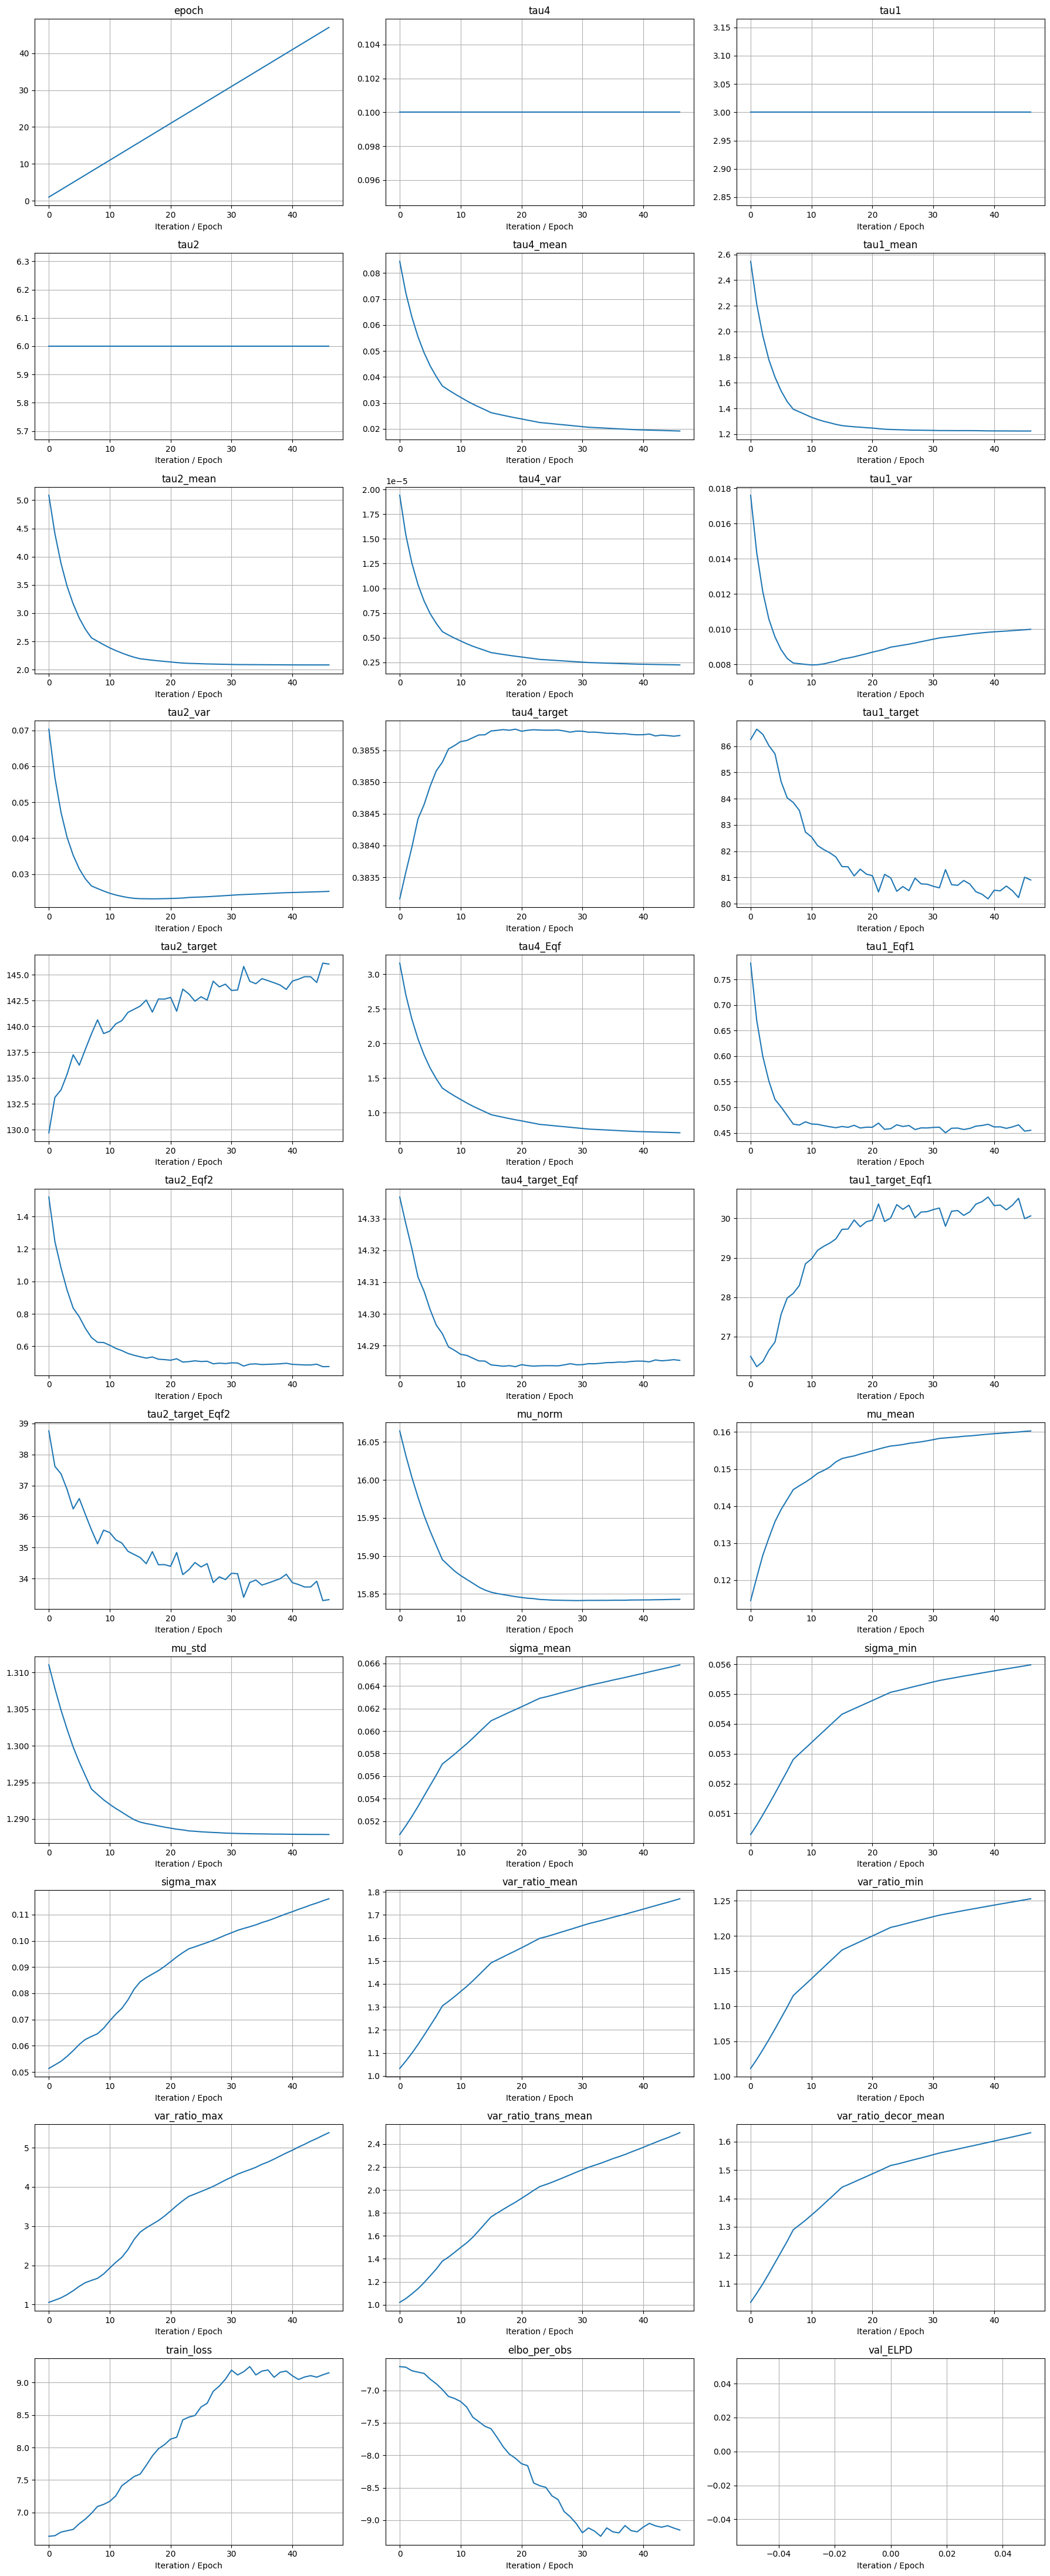

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



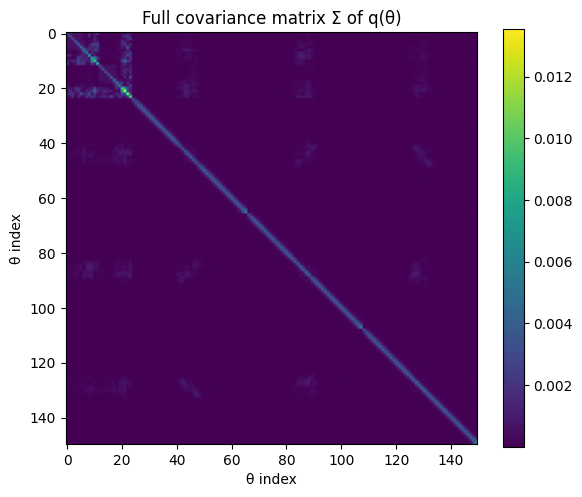

In [13]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


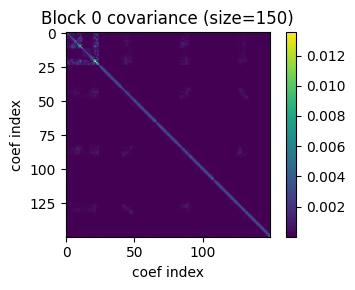

In [14]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:
import torch
import math
from torch.nn.utils.stateless import _reparametrize_module

def sample_bayesian_predictive(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    n_samples: int,
    S: int = 32,
    decor_present: bool = True,
):
    """
    Draw samples from the Bayesian predictive:
        p(y) ≈ (1/S) ∑_s p(y | θ_s, τ_s)
    by:
      - sampling θ_s ~ q(θ)
      - sampling τ_s ~ q(τ) (if tau_nodes is not None)
      - for each s, drawing n_samples/S from model with those parameters
    """
    device = model.device
    S = min(S, n_samples)
    n_per = math.ceil(n_samples / S)

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    # sample taus for each s (or fall back to hyperparameters)
    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    samples_all = []

    for s in range(S):
        theta_s = theta_samples[s]

        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            # if your sample() does not take taus, you can instead
            # stash them into model.hyperparameter[...] before calling sample
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            y_s = model.sample(n_per)  # shape [n_per, d]
            samples_all.append(y_s)

    y_cat = torch.cat(samples_all, dim=0)
    return y_cat[:n_samples]


def log_prob_bayesian_mixture(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    y: torch.Tensor, # [N, d]
    S: int = 32,
    decor_present: bool = True,
):
    """
    Compute log p(y) under the Bayesian predictive via log-mean-exp over θ, τ.
    """
    device = model.device
    N = y.shape[0]

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    logps = []

    for s in range(S):
        theta_s = theta_samples[s]
        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            # adapt this to your GTM's density API
            # e.g. if you have model.log_prob(y):
            ll_s = model.log_likelihood(y)     # [N]
            logps.append(ll_s)

    logps = torch.stack(logps, dim=0)   # [S, N]

    # log mean exp over S
    m, _ = torch.max(logps, dim=0, keepdim=True)
    log_mean = m.squeeze(0) + torch.log(torch.mean(torch.exp(logps - m), dim=0))  # [N]

    return log_mean  # [N]


In [16]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

log_likelihood_train_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_train,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_validate_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_validate,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_test_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_test,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [17]:
@torch.no_grad()
def sanity_check_covariance(VI):
    L_blocks = VI._build_L_blocks()

    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        print(f"\n[Block {b}] size={idx.numel()}")

        # shape
        print("  L.shape =", tuple(L.shape))

        # lower-triangular check
        upper = L.triu(diagonal=1)
        print("  max upper =", upper.abs().max().item())

        # diag positive?
        diag = torch.diag(L)
        print("  diag min =", diag.min().item(),
              "diag max =", diag.max().item())

        # positive definite?
        Sigma = L @ L.T
        eigvals = torch.linalg.eigvalsh(Sigma)
        print("  λ_min =", eigvals.min().item(),
              "λ_max =", eigvals.max().item(),
              "cond =", eigvals.max().item() / eigvals.min().item())

sanity_check_covariance(output["vi_model"])



[Block 0] size=150
  L.shape = (150, 150)
  max upper = 0.0
  diag min = 0.055967431515455246 diag max = 0.05600375682115555
  λ_min = 2.047970519925002e-05 λ_max = 0.02647244930267334 cond = 1292.6186702942764


In [18]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [19]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0633
KLD GTM      Train Data:  0.0019
KLD Gaussian Train Data:  0.1094
KLD Copula   Train Data:  -0.0022

KLD BGTM      Test  Data:  0.0649
KLD GTM      Test  Data:  0.0137
KLD Gaussian Test  Data:  0.1093
KLD Copula   Test  Data:  0.0035


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [20]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = sample_bayesian_predictive(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    n_samples=10_000,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


In [21]:
D = VI.mu.numel()
print("D =", D)
print("num_diag =", VI.num_diag)
print("block_sizes =", VI.block_sizes)
print("L_unconstrained length =", VI.L_unconstrained.numel())

expected_tris = sum(k * (k + 1) // 2 for k in VI.block_sizes)
print("expected_tris =", expected_tris)


D = 150
num_diag = 0
block_sizes = [150]
L_unconstrained length = 11325
expected_tris = 11325


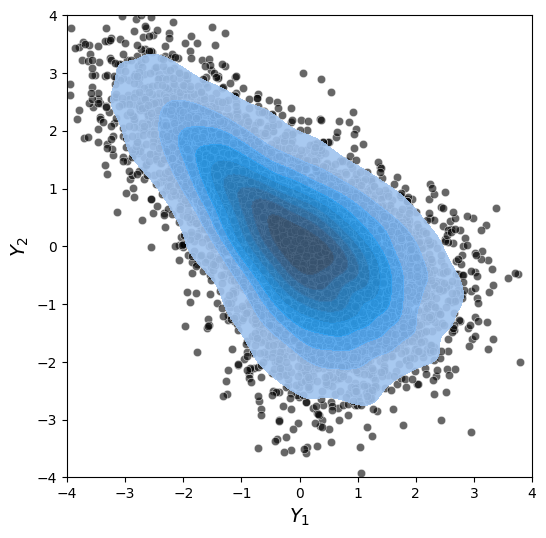

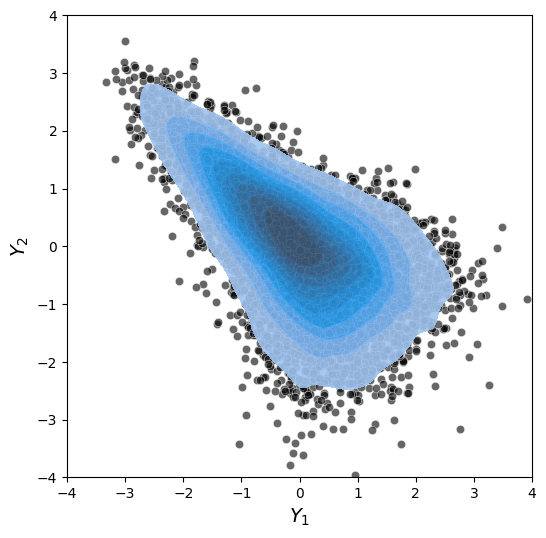

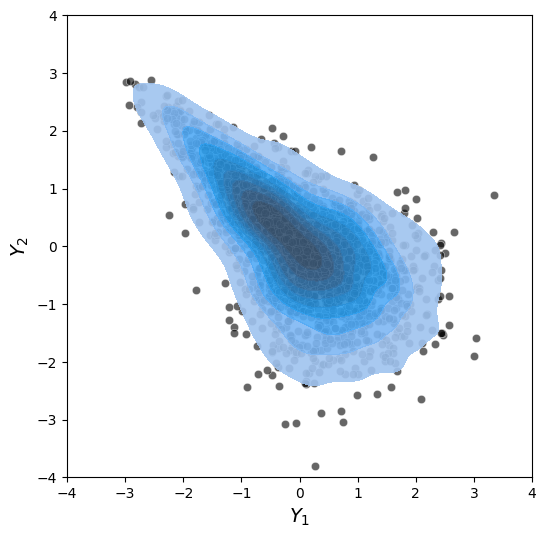

In [22]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [23]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [24]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


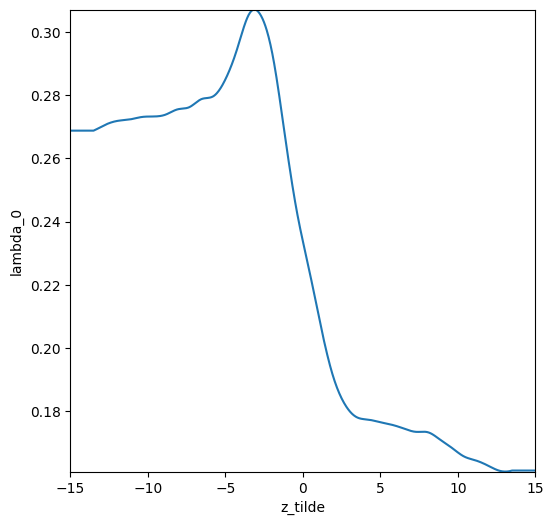

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


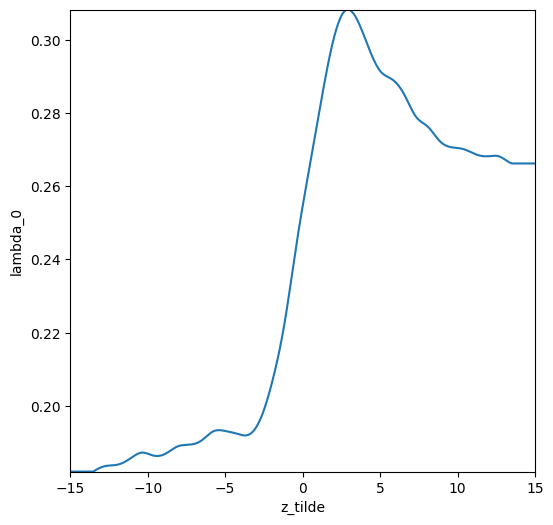

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


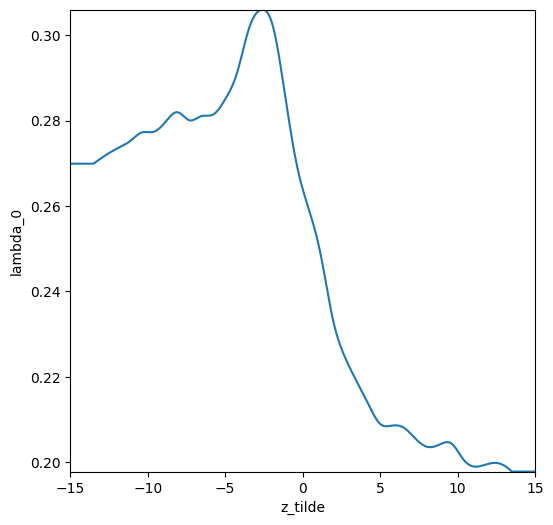

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)